In [1]:
import tensorflow as tf
import numpy as np

In [2]:
import pandas as pd
data=pd.read_csv('data.csv')
data.head()

,Date,Oil Investments,Gold Investments,Comp Stock,Other sharesInvestments
0,31-12-2009,0.025417,0.000150,0.017354,0.006848
1,04-01-2010,0.026830,0.001097,0.015565,-0.004609
2,05-01-2010,0.002699,0.001560,0.001729,0.005900
3,06-01-2010,0.021688,0.006009,-0.015906,-0.018116
4,07-01-2010,-0.006256,0.000221,-0.001849,-0.017013


In [3]:
cols=['date', 'oil', 'gold', 'comp', 'other']
data.columns=cols
data.head()

,date,oil,gold,comp,other
0,31-12-2009,0.025417,0.000150,0.017354,0.006848
1,04-01-2010,0.026830,0.001097,0.015565,-0.004609
2,05-01-2010,0.002699,0.001560,0.001729,0.005900
3,06-01-2010,0.021688,0.006009,-0.015906,-0.018116
4,07-01-2010,-0.006256,0.000221,-0.001849,-0.017013


In [4]:
data['date']=pd.to_datetime(data['date'])

In [5]:
data['year']=pd.DatetimeIndex(data['date']).year

In [6]:
data.sort_values(by='date', inplace=True)

In [7]:
data.set_index(['date'], inplace=True)

In [8]:
oil=data.iloc[:,[0,4]]
oil.head()

,oil,year
date,,
2009-12-31,0.025417,2009
2010-01-02,0.021414,2010
2010-01-03,-0.012669,2010
2010-01-04,0.012942,2010
2010-01-06,-0.017568,2010


In [9]:
# Lets remove this and the entry for 2009
oil.drop(pd.DatetimeIndex(['2009-12-31']), inplace=True)
oil.drop(pd.DatetimeIndex(['2017-03-07']), inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [10]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i)
    # Reshape data from (history_size,) to (history_size, 1)
    data.append(np.reshape(dataset[indices], (history_size, 1)))
    labels.append(dataset[i+target_size])
  return np.array(data), np.array(labels)


In [11]:
univariate_past_history = 10
univariate_future_target = 0

x_train_oil, y_train_oil = univariate_data(oil['oil'].values, 0, 1762,
                                           univariate_past_history,
                                           univariate_future_target)
x_val_oil, y_val_oil = univariate_data(oil['oil'].values, 1762, None,
                                       univariate_past_history,
                                       univariate_future_target)

In [12]:
BATCH_SIZE = 32 # bacth size in batch-SGD/variants
BUFFER_SIZE = 1000 # for shuffling the dataset

train_univariate_oil = tf.data.Dataset.from_tensor_slices((x_train_oil, y_train_oil))
train_univariate_oil = train_univariate_oil.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate_oil = tf.data.Dataset.from_tensor_slices((x_val_oil, y_val_oil))
val_univariate_oil = val_univariate_oil.batch(BATCH_SIZE).repeat()

print(train_univariate_oil)
print(val_univariate_oil)

<RepeatDataset shapes: ((None, 10, 1), (None,)), types: (tf.float64, tf.float64)>
<RepeatDataset shapes: ((None, 10, 1), (None,)), types: (tf.float64, tf.float64)>


In [13]:
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(8, input_shape=x_train_oil.shape[-2:]),
    tf.keras.layers.Dense(1)
])

simple_lstm_model.compile(optimizer='adam', loss='mae')

In [14]:
STEPS_PER_EPOCH = 200
EPOCHS = 20

simple_lstm_model.fit(train_univariate_oil, epochs=EPOCHS,
                      steps_per_epoch=STEPS_PER_EPOCH,
                      validation_data=val_univariate_oil, validation_steps=50)

Epoch 1/20
200/200 [==============================] - 1s 5ms/step - loss: 0.0157 - val_loss: 0.0129
Epoch 2/20
200/200 [==============================] - 1s 3ms/step - loss: 0.0156 - val_loss: 0.0121
Epoch 3/20
200/200 [==============================] - 1s 3ms/step - loss: 0.0157 - val_loss: 0.0124
Epoch 4/20
200/200 [==============================] - 1s 4ms/step - loss: 0.0155 - val_loss: 0.0122
Epoch 5/20
200/200 [==============================] - 1s 3ms/step - loss: 0.0155 - val_loss: 0.0121
Epoch 6/20
200/200 [==============================] - 1s 3ms/step - loss: 0.0157 - val_loss: 0.0121
Epoch 7/20
200/200 [==============================] - 1s 3ms/step - loss: 0.0154 - val_loss: 0.0121
Epoch 8/20
200/200 [==============================] - 1s 3ms/step - loss: 0.0157 - val_loss: 0.0122
Epoch 9/20
200/200 [==============================] - 1s 3ms/step - loss: 0.0156 - val_loss: 0.0128
Epoch 10/20
200/200 [==============================] - 1s 3ms/step - loss: 0.0155 - val_loss: 0.0122

In [15]:
pred_oil=simple_lstm_model.predict(x_val_oil)

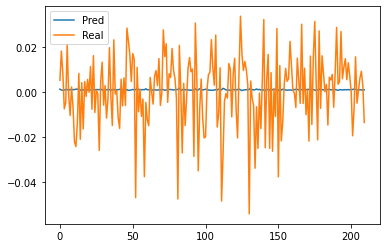

In [17]:
import matplotlib.pyplot as plt
plt.plot(pred_oil, label='Pred')
plt.plot(y_val_oil, label='Real')
plt.legend()
plt.show()

In [18]:
# The predictions are not that good

Epoch 1/7
100/100 [==============================] - 1s 6ms/step - loss: 0.0159 - val_loss: 0.0126
Epoch 2/7
100/100 [==============================] - 0s 4ms/step - loss: 0.0155 - val_loss: 0.0129
Epoch 3/7
100/100 [==============================] - 0s 4ms/step - loss: 0.0156 - val_loss: 0.0120
Epoch 4/7
100/100 [==============================] - 0s 4ms/step - loss: 0.0155 - val_loss: 0.0120
Epoch 5/7
100/100 [==============================] - 0s 4ms/step - loss: 0.0160 - val_loss: 0.0120
Epoch 6/7
100/100 [==============================] - 0s 4ms/step - loss: 0.0157 - val_loss: 0.0123
Epoch 7/7
100/100 [==============================] - 0s 4ms/step - loss: 0.0154 - val_loss: 0.0121


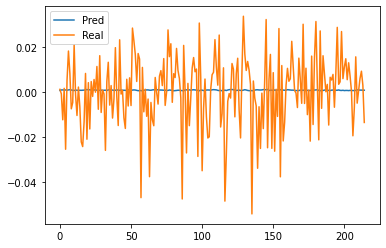

In [23]:
univariate_past_history = 5
univariate_future_target = 0

x_train_oil, y_train_oil = univariate_data(oil['oil'].values, 0, 1762,
                                           univariate_past_history,
                                           univariate_future_target)
x_val_oil, y_val_oil = univariate_data(oil['oil'].values, 1762, None,
                                       univariate_past_history,
                                       univariate_future_target)


BATCH_SIZE = 32 # bacth size in batch-SGD/variants
BUFFER_SIZE = 1000 # for shuffling the dataset

train_univariate_oil = tf.data.Dataset.from_tensor_slices((x_train_oil, y_train_oil))
train_univariate_oil = train_univariate_oil.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate_oil = tf.data.Dataset.from_tensor_slices((x_val_oil, y_val_oil))
val_univariate_oil = val_univariate_oil.batch(BATCH_SIZE).repeat()


simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(3, input_shape=x_train_oil.shape[-2:]),
    tf.keras.layers.Dense(1, activation='linear')
])

simple_lstm_model.compile(optimizer='adam', loss='mae')

STEPS_PER_EPOCH = 100
EPOCHS = 7

simple_lstm_model.fit(train_univariate_oil, epochs=EPOCHS,
                      steps_per_epoch=STEPS_PER_EPOCH,
                      validation_data=val_univariate_oil, validation_steps=50)

pred_oil=simple_lstm_model.predict(x_val_oil)

plt.plot(pred_oil, label='Pred')
plt.plot(y_val_oil, label='Real')
plt.legend()
plt.show()

In [24]:
# The random forest model was better